# Hybrid DL + NLP — Inference & Evaluation Notebook (SMS Spam)

This notebook demonstrates **inference and evaluation only** for a trained **TF-IDF + MLP (PyTorch)** text classifier.

✅ The full pipeline (data prep → preprocessing → vectorization → training → evaluation → report) is implemented and executed via Python scripts under `src/`.

> **This notebook is intended for:**
- Demonstration
- Inspection
- Sanity checks
- Lightweight evaluation review

🚫 **Not for training or experimentation.**


# Hybrid DL + NLP — Inference & Evaluation Notebook (SMS Spam)

This notebook demonstrates **inference and evaluation only** for a trained **TF-IDF + MLP (PyTorch)** text classifier.

✅ The full pipeline (data prep → preprocessing → vectorization → training → evaluation → report) is implemented and executed via Python scripts under `src/`.

> **This notebook is intended for:**
- Demonstration
- Inspection
- Sanity checks
- Lightweight evaluation review

🚫 **Not for training or experimentation.**


In [1]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import torch
from torch import nn

In [2]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [3]:
# Define paths for project structure
ROOT = Path("..").resolve()  # notebooks/ -> project root
PROCESSED = ROOT / "data" / "processed"
OUTPUTS = ROOT / "outputs"
MODELS = OUTPUTS / "models"
RESULTS = OUTPUTS / "results"

# Define specific file paths
VEC_PATH = PROCESSED / "tfidf_vectorizer.joblib"
LE_PATH  = PROCESSED / "label_encoder.joblib"
MODEL_PATH = MODELS / "mlp_tfidf.pt"
METRICS_PATH = RESULTS / "A_test_metrics.joblib"

print("ROOT:", ROOT)
print("Vectorizer exists:", VEC_PATH.exists())
print("LabelEncoder exists:", LE_PATH.exists())
print("Model exists:", MODEL_PATH.exists())
print("Metrics exists:", METRICS_PATH.exists())
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")


ROOT: C:\Users\ORENS\module2-deep-learning-nlp\03_hybrid_dl_nlp
Vectorizer exists: True
LabelEncoder exists: True
Model exists: True
Metrics exists: True
Device: cpu


## Project Summary

- **Task:** Binary text classification (Spam vs Ham)
- **Dataset:** SMS Spam Collection (prepared CSV)
- **Feature Engineering:** TF-IDF (Bag-of-Words)
- **Model:** MLP (PyTorch)
- **Evaluation:** Hold-out **TEST** set (Stage 6)
- **Artifacts:**
  - `tfidf_vectorizer.joblib`
  - `label_encoder.joblib`
  - `mlp_tfidf.pt`
  - `A_test_metrics.joblib`


In [4]:
# Load artifacts
tfidf = joblib.load(VEC_PATH)
label_encoder = joblib.load(LE_PATH)

metrics = joblib.load(METRICS_PATH) if METRICS_PATH.exists() else None

label_names = list(label_encoder.classes_)
print("Labels:", label_names)
print("TF-IDF vocab size:", len(getattr(tfidf, "vocabulary_", {})))

if metrics:
    print("Saved TEST accuracy:", metrics.get("accuracy"))


Labels: ['ham', 'spam']
TF-IDF vocab size: 3295
Saved TEST accuracy: 0.9808612440191388


## Model Definition (MLP)

The architecture matches the training script (Stage 5).
We load weights from `outputs/models/mlp_tfidf.pt`.


In [5]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    # Define forward pass
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# infer input_dim from vectorizer settings
input_dim = tfidf.transform(["test"]).shape[1]
num_classes = len(label_names)

model = MLP(input_dim=input_dim, num_classes=num_classes, hidden_dim=256, dropout=0.2).to(device)
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

print("✅ Model loaded")
print("input_dim:", input_dim, "num_classes:", num_classes)


✅ Model loaded
input_dim: 3295 num_classes: 2


## Quick Inference (Single / Batch)

We vectorize raw text using the saved TF-IDF vectorizer and run model inference.


In [6]:
# Define prediction function
@torch.no_grad()
def predict_texts(texts):
    X = tfidf.transform(texts)
    X_dense = X.toarray().astype(np.float32)
    xb = torch.tensor(X_dense).to(device)
    logits = model(xb)
    pred = torch.argmax(logits, dim=1).cpu().numpy()
    return label_encoder.inverse_transform(pred)

samples = [
    "WINNER!! You have won a free ticket. Call now!",
    "Hey, are we still meeting today at 7?"
]

preds = predict_texts(samples)
list(zip(samples, preds))


[('WINNER!! You have won a free ticket. Call now!', 'spam'),
 ('Hey, are we still meeting today at 7?', 'ham')]

## Load TEST Split and Evaluate (Notebook Sanity Check)

Stage 6 already evaluated on TEST and saved `A_test_metrics.joblib`.

Here we optionally re-check accuracy in the notebook for sanity.


In [7]:
test_clean_path = PROCESSED / "test_clean.csv"
df_test = pd.read_csv(test_clean_path)

# Expect columns: text_clean, label
texts = df_test["text_clean"].astype(str).tolist()
y_true = df_test["label"].astype(str).tolist()

y_pred = predict_texts(texts)

acc = accuracy_score(y_true, y_pred)
print("✅ Notebook TEST accuracy:", round(acc, 4))


✅ Notebook TEST accuracy: 0.9809


## Confusion Matrix


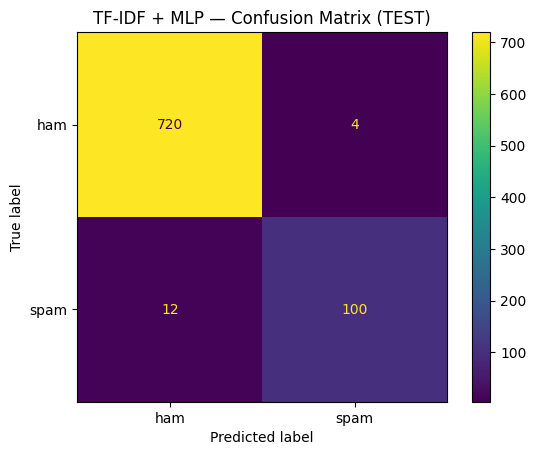

In [8]:
cm = confusion_matrix(y_true, y_pred, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(values_format="d")
plt.title("TF-IDF + MLP — Confusion Matrix (TEST)")
plt.show()


## Classification Report


In [9]:
print(classification_report(y_true, y_pred, labels=label_names))


              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       724
        spam       0.96      0.89      0.93       112

    accuracy                           0.98       836
   macro avg       0.97      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836



## Saved Metrics (Stage 6 Output)

This section reads the official pipeline metrics from:
`outputs/results/A_test_metrics.joblib`


In [10]:
if metrics:
    summary = {
        "experiment": metrics.get("experiment"),
        "accuracy": metrics.get("accuracy"),
        "n_test": metrics.get("n_test"),
    }
    pd.DataFrame([summary])
else:
    print("No saved metrics found.")


## Conclusion

✅ The model is loaded correctly  
✅ Inference works end-to-end  
✅ TEST evaluation is reproducible  
✅ Outputs are saved via the pipeline scripts

This notebook is intentionally lightweight and focuses on **results**.
